Read the Competition Overview on Kaggle https://www.kaggle.com/t/a154f28787174b628a2b7eaa238a5c12

## PROBLEM DESCRIPTION : 

Airbnb stands for "AirBed and Breakfast", is an online platform of connecting people who are looking for accommodations in specific locales with people who have their rooms for rent in the short-term stays around the world through a mobile sharing application. On the website, Airbnb offers a huge range of options where homeowners can establish a listing for their house, which includes a written description, pictures, a list of amenities, pricing information and details about the neighborhood. Travelers can use filters to search for holiday accommodation that’s right for them. Airbnb is also based on trust, it allows both guests and hosts have the opportunity to leave a review and provide feedback about their experience via the rating system. The growing popularity of Airbnb has resulted in a substantial increase in the number of property listings in cities like Melbourne. However, accurately determining the optimal price for a property is a challenging task for hosts due to the multitude of factors that can influence rental rates. Therefore, the problem at hand is to develop a predictive model that can estimate the listed prices of Airbnb properties in Melbourne based on various Airbnb characteristics and regression models. To understand the mobilizing and effect of Airbnb prices in accommodations market, we presented a research through Airbnb listing prices for Melbourne based on various characteristics of the listed properties. Price analysis of Airbnb properties benefits hosts, guests, and industry stakeholders by providing market understanding, enabling revenue optimization, supporting decision making, promoting fairness, and generating valuable insights about the vacation rental industry. This research conducted on the given dataset which is divided into 2 sets: train and test. For the train data, it provides overall 7000 rows and 61 columns while test data has 3000 rows and 60 columns. The main objective of the research is to develop a machine learning model from the train data to optimize performance, from that, evaluate and estimate the price of the listings given in the test data. To ensure our data is cleaned and properly investigated, we need to remove any inconsistencies or missing values, then, identify the most significant features that impact the rental prices of Airbnb properties in Melbourne and extract relevant information from the dataset. Assess their performance using appropriate evaluation metrics and select the model with the highest predictive accuracy. In term of main data characteristics, this large-scale dataset has a mix of categorical variables (e.g., property type, amenities) and numerical variables (e.g., number of bedrooms, host response rate, review). The categorical variables further contain a mix of nominal (such as Host’s identity verified) and ordinal features. There are also multiple variables with text values and numeric values that describe different aspects of Airbnb properties in Melbourne. These features include location-related information, property-specific details, host-related attributes, and amenities provided. We also notice that our data sets in both test and train contain a number of missing values which were eventually imputed/filled in before our model was trained. The successful completion of this project will provide Airbnb stakeholders in Melbourne with a reliable tool for determining appropriate rental prices for their properties. By incorporating various Airbnb characteristics and utilizing regression models, they can make informed decisions about pricing, leading to improved occupancy rates, increased revenue, and enhanced overall user experience on the Airbnb platform.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn import linear_model, metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse



df_train_raw = pd.read_csv('/Users/aadharbaheti/Downloads/analytics-group-assignment-s1-2023/train.csv')
df_test = pd.read_csv('/Users/aadharbaheti/Downloads/analytics-group-assignment-s1-2023/test.csv')
df_metaData = pd.read_csv('/Users/aadharbaheti/Downloads/analytics-group-assignment-s1-2023/metaData.csv')

In [2]:
#given the large data set, we want to avoid our output being truncated. 
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 999)

In [3]:
df_train_raw['type'] = "train"

df_test['type'] = "test"

combined_df = pd.concat([df_train_raw,df_test], ignore_index=True)

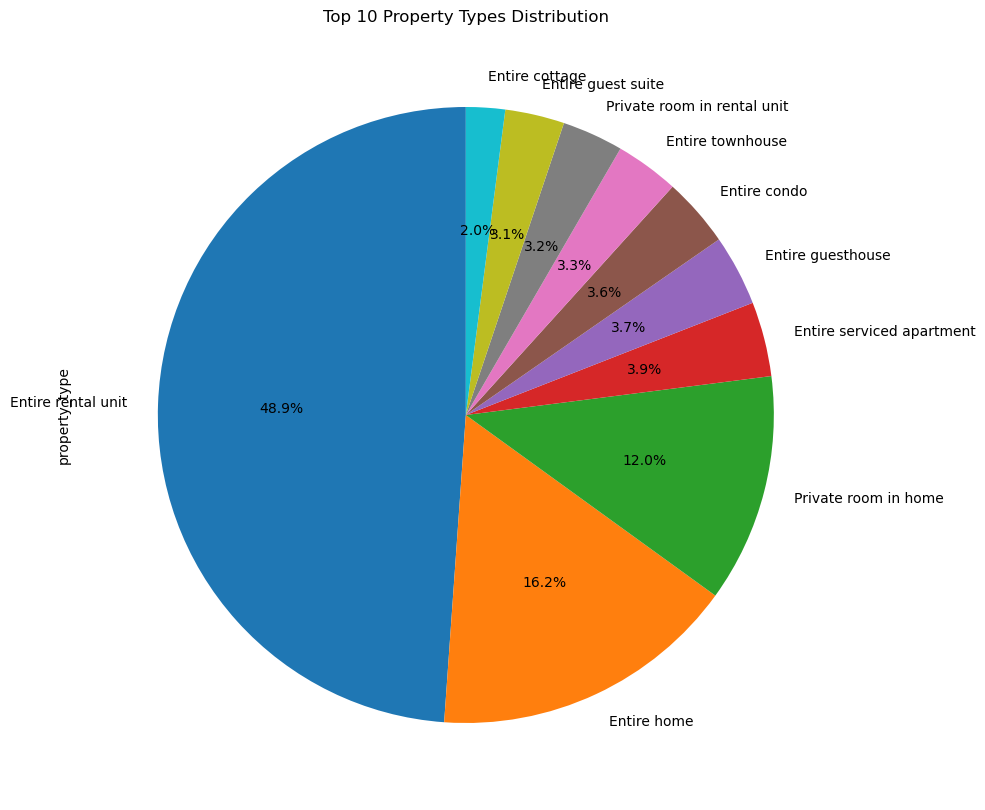

In [4]:
plt.figure(figsize=(12, 10))
property_type_counts = df_train_raw['property_type'].value_counts()

# Display only the top N property types (adjust N as needed)
top_n = 10
property_type_counts = property_type_counts.head(top_n)

property_type_counts.plot.pie(autopct='%1.1f%%', startangle=90,legend=None)
plt.title(f'Top {top_n} Property Types Distribution')
plt.show()


Text(0.5, 1.0, 'Bathroom Distribution\n')

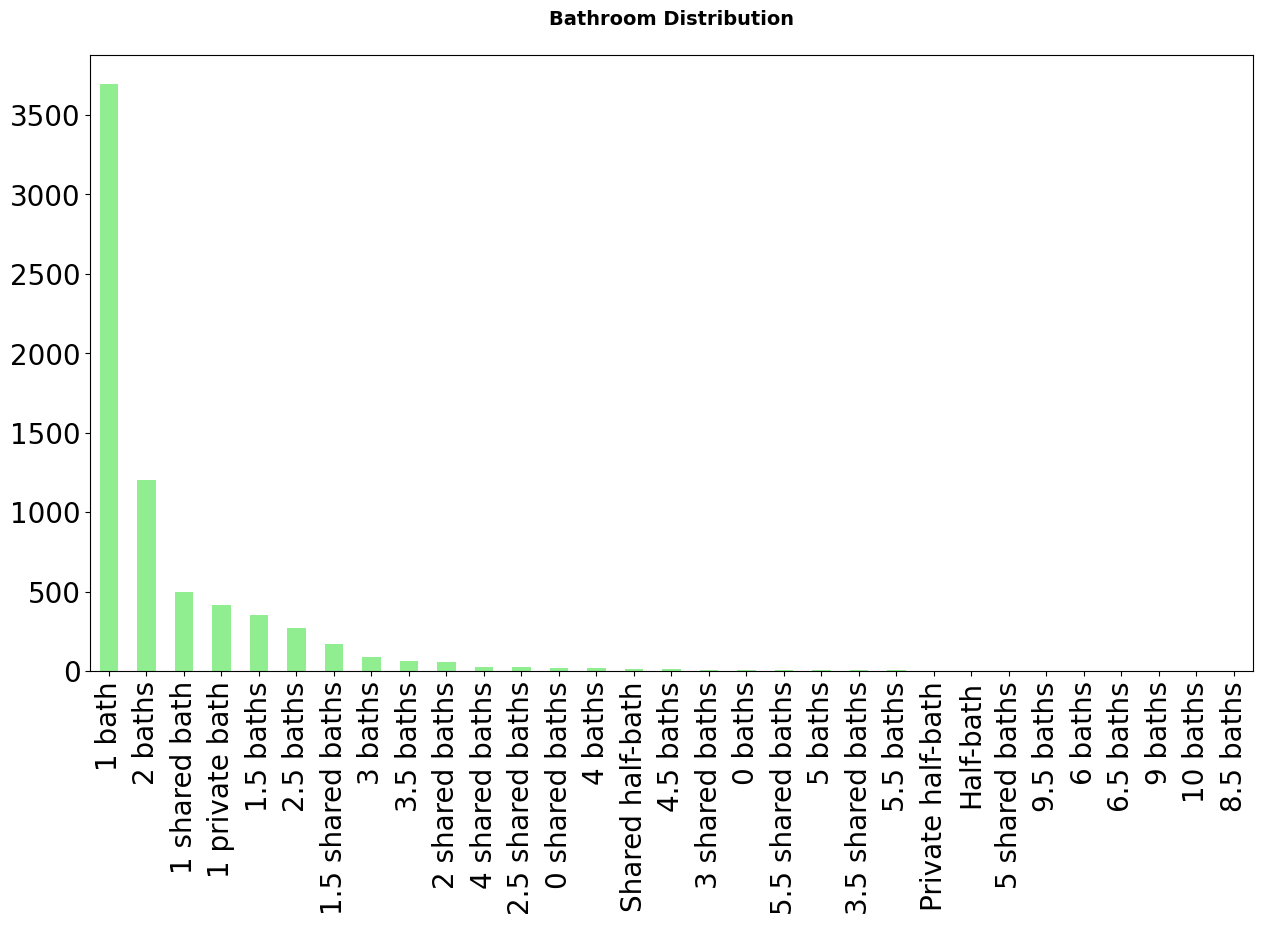

In [5]:
property_df = df_train_raw.bathrooms.value_counts()
property_df.columns = ['bathrooms']
property_df.plot.bar(y= 'bathrooms', 
                     color = 'LightGreen',
                     fontsize = 20,
                     legend = False,
                     figsize= (15, 8))

plt.title('Bathroom Distribution\n', fontsize=14, fontweight='bold')

Text(0.5, 1.0, 'Room Type Distribution\n')

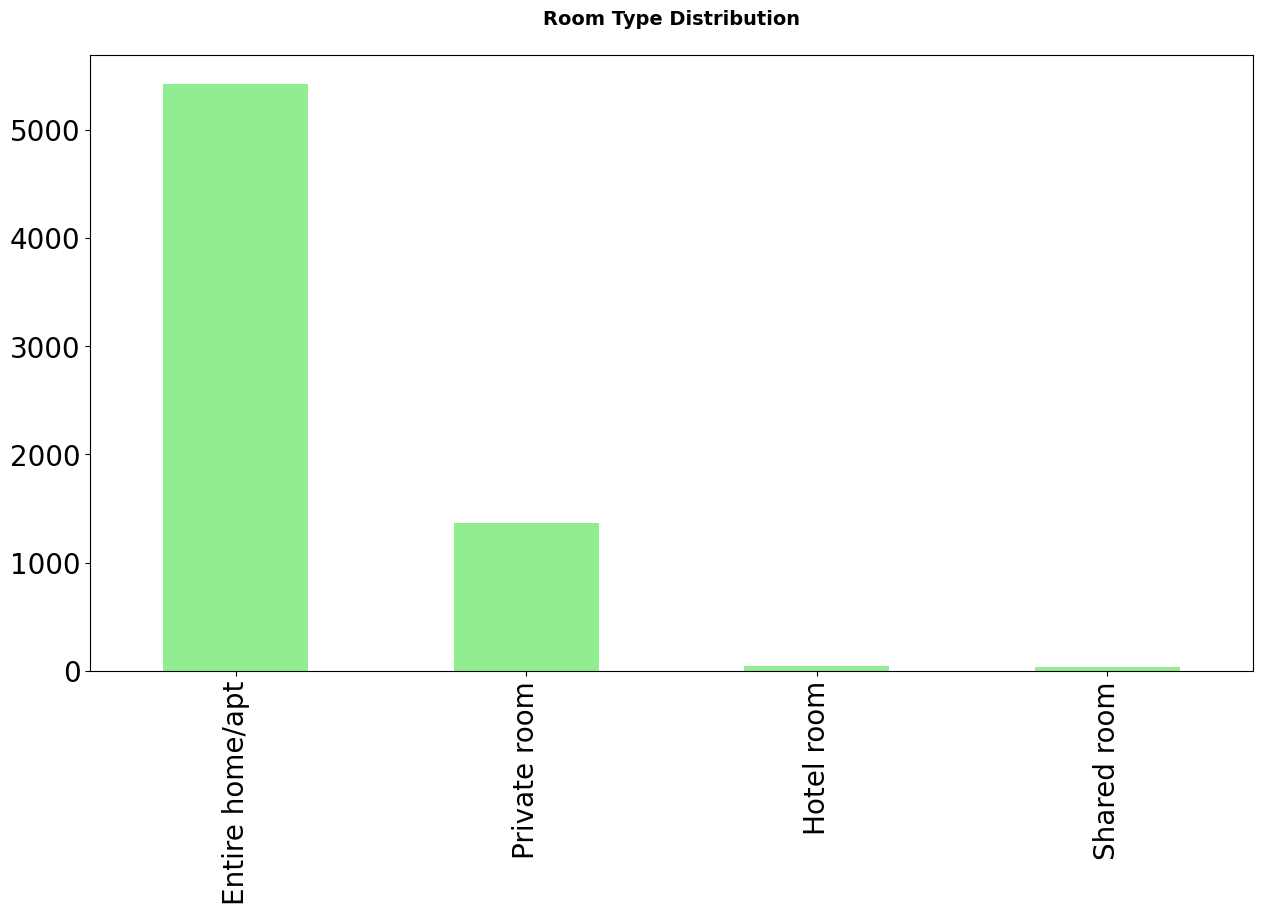

In [6]:
property_df = df_train_raw.room_type.value_counts()
property_df.columns = ['room_type']
property_df.plot.bar(y= 'room_type', 
                     color = 'LightGreen',
                     fontsize = 20,
                     legend = False,
                     figsize= (15, 8))

plt.title('Room Type Distribution\n', fontsize=14, fontweight='bold')

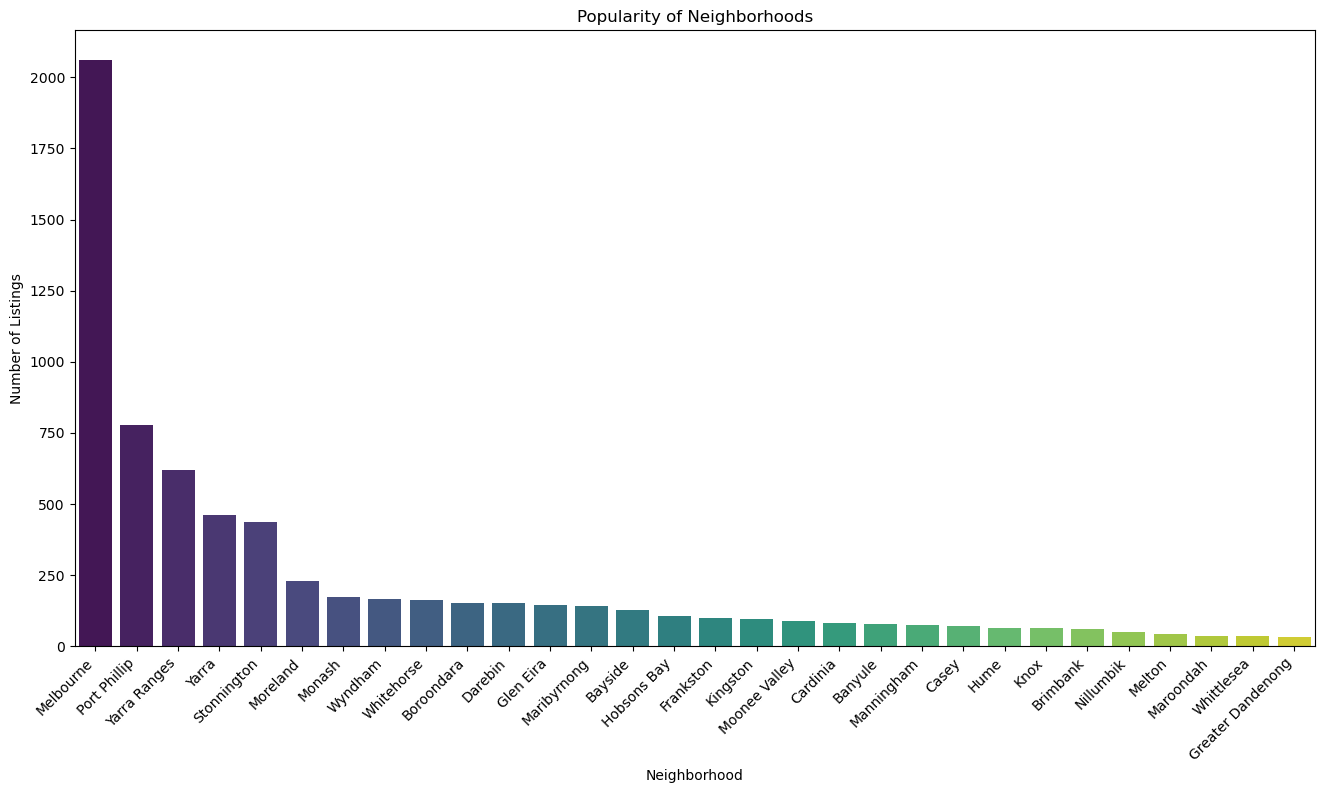

In [7]:
neighborhood_counts = df_train_raw['neighbourhood_cleansed'].value_counts()


plt.figure(figsize=(16, 8))
sns.barplot(x=neighborhood_counts.index, y=neighborhood_counts.values, palette='viridis')
plt.title('Popularity of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right')
plt.show()

In [8]:
#removing $ from the price column to visualize the price plots

df_train_raw['price'] = df_train_raw['price'].astype(str)
df_train_raw['price'] = df_train_raw['price'].str.replace('$', '')
df_train_raw['price'] = df_train_raw['price'].str.replace(',', '')
df_train_raw['price'] = df_train_raw['price'].astype(float)

/var/folders/n7/nx2jtvtx6mv45smlrw1sk3s00000gn/T/ipykernel_55165/2961708583.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_train_raw['price'] = df_train_raw['price'].str.replace('$', '')


In [9]:
# checking the mean price of the listings

df_train_raw['price'].describe()

count      7000.000000
mean        285.649714
std        2325.453324
min          25.000000
25%         117.000000
50%         172.000000
75%         268.000000
max      145160.000000
Name: price, dtype: float64

## Data Cleaning, Missing Observations and Feature Engineering {-}

In [10]:
# Defining the columns to impute (excluding 'price')
columns_to_impute = [
    'name', 'description', 'neighborhood_overview', 'host_location',
    'host_about', 'host_response_time', 'host_response_rate',
    'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
    'neighbourhood', 'neighbourhood_cleansed', 'property_type',
    'room_type', 'bathrooms', 'bedrooms', 'beds', 'availability_365',
    'first_review', 'last_review', 'review_scores_rating',
    'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'reviews_per_month'
]

# Imputing missing values for numerical columns with the mean
numerical_columns = combined_df.select_dtypes(include=['float64']).columns
combined_df[numerical_columns] = combined_df[numerical_columns].fillna(combined_df[numerical_columns].mean())

# Imputing missing values for categorical columns with a placeholder value, such as 'Unknown'
categorical_columns = columns_to_impute
combined_df[categorical_columns] = combined_df[categorical_columns].fillna('Unknown')

# Checking if there are any remaining missing values in the combined dataset
missing_values = combined_df.isnull().sum()

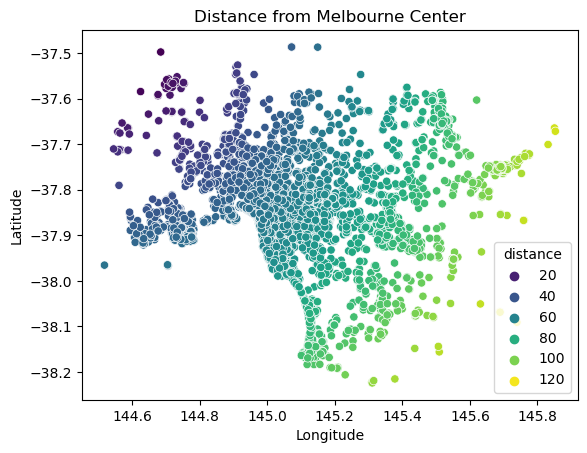

In [11]:
## FEATURE 1 
melbourne_center = (-37.4912, 144.5746)  # Melbourne center coordinates

def calculate_distance(latitude, longitude):
    lat1, lon1 = np.radians(melbourne_center)
    lat2, lon2 = np.radians((latitude, longitude))
    
    # Earth's radius in kilometers
    radius = 6371

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = radius * c

    return distance

combined_df['distance'] = combined_df.apply(lambda x: calculate_distance(x['latitude'], x['longitude']), axis=1)


sns.scatterplot(x='longitude', y='latitude', hue='distance', data=combined_df, palette='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distance from Melbourne Center')
plt.show()

In [12]:
## FEATURE 2 
combined_df['bathrooms'] = combined_df['bathrooms'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

In [13]:
#FEATURE 3 :  Amenities Count
combined_df['amenities_count'] = combined_df['amenities'].str.count(',') + 1

In [14]:
##FEATURE 4: host verification
combined_df['has_host_verification'] = combined_df['host_verifications'].str.len() > 0

In [15]:
## FEATURE 5 
categorical_columns = ['property_type', 'room_type', 'has_availability', 'instant_bookable']
combined_df = pd.get_dummies(combined_df, columns=categorical_columns, drop_first=True)

In [16]:
# Feature 6: Average Review Score
# Calculating the average of all review score columns
review_score_columns = [
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]
combined_df['avg_review_score'] = combined_df[review_score_columns].mean(axis=1)

In [17]:
# List of columns to drop from the combined_df
columns_to_drop = [
     'source', 'name', 'description', 'neighborhood_overview', 'host_name',
    'host_location', 'host_about', 'host_response_time', 'host_response_rate',
    'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
    'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
    'neighbourhood', 'neighbourhood_cleansed', 'amenities','first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value'
]
combined_df = combined_df.drop(columns=columns_to_drop)

In [18]:
# Converting the "price" column to a numeric data type (float or int)
combined_df['price'] = combined_df['price'].str.replace('[\$,]', '', regex=True).astype(float)

In [19]:
combined_df = combined_df.drop(columns='host_since')

In [20]:
missing_values = combined_df.drop(columns=['price']).isnull().sum()

# Identifying columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
print(columns_with_missing_values)

bathrooms    36
dtype: int64


In [21]:
# Imputing missing values in the 'bathrooms' column with the mean
mean_bathrooms = combined_df['bathrooms'].mean()
combined_df['bathrooms'] = combined_df['bathrooms'].fillna(mean_bathrooms)

In [22]:
df_train = combined_df[combined_df['type'] == 'train']
df_test = combined_df[combined_df['type'] == 'test']

In [23]:
df_train.drop(['type'], axis = 1, inplace = True)
df_test.drop(['type'], axis = 1, inplace = True)

/var/folders/n7/nx2jtvtx6mv45smlrw1sk3s00000gn/T/ipykernel_55165/2470247972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['type'], axis = 1, inplace = True)
/var/folders/n7/nx2jtvtx6mv45smlrw1sk3s00000gn/T/ipykernel_55165/2470247972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['type'], axis = 1, inplace = True)


In [24]:
df_test.drop(['price'], axis = 1, inplace = True)

/var/folders/n7/nx2jtvtx6mv45smlrw1sk3s00000gn/T/ipykernel_55165/1940631017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['price'], axis = 1, inplace = True)


<AxesSubplot:title={'center':'Price'}>

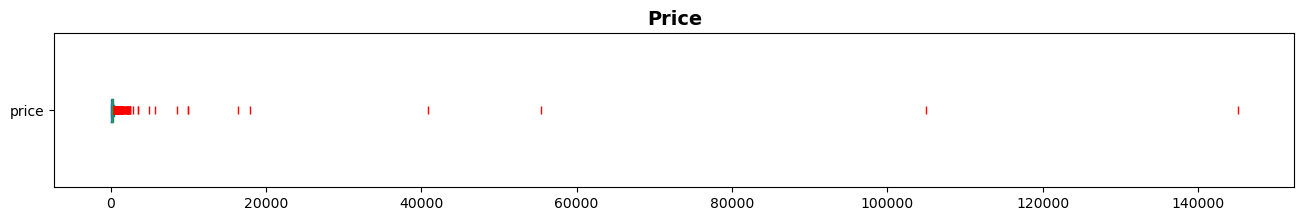

In [25]:
#plot the price distribution box
box_plot = dict(markerfacecolor='r', markeredgecolor='r', marker='|')
price_dist = combined_df['price'].plot(kind='box', vert=False, flierprops=box_plot, title = "Price", figsize=(16,2));
plt.title('Price', fontsize=14, fontweight='bold')
price_dist

In [26]:
# 75% of the apartments charge up to 250$ - but the maximum value is over $100,000
# let's decide on a limit of $800, and drop all outliers that charge more than that
df_train.drop(df_train[(df_train.price > 800)].index, axis=0, inplace = True)

/var/folders/n7/nx2jtvtx6mv45smlrw1sk3s00000gn/T/ipykernel_55165/484284765.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(df_train[(df_train.price > 800)].index, axis=0, inplace = True)


## Fit and tune a forecasting model/Submit predictions/Report score 

In [27]:
# creating target and features
a = df_train.drop(['price'], axis = 1)
b = df_train.price

# splitting our data
X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.3, random_state=13)

In [28]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [29]:
#using linear regression
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
r2_lr = metrics.r2_score(y_test, reg.predict(X_test))

y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

print (f"r2: {round(r2_lr, 5)}")

r2: -2.4183075858396905e+19


In [30]:
#using ridge regression

ridge = linear_model.Ridge(alpha=100)

ridge.fit(X_train, y_train)

y_test_pred_rr = ridge.predict(X_test)

r2_rr = metrics.r2_score(y_test, y_test_pred_rr)

print(f"R2 (Ridge Regression): {round(r2_rr, 3)}")


R2 (Ridge Regression): 0.48


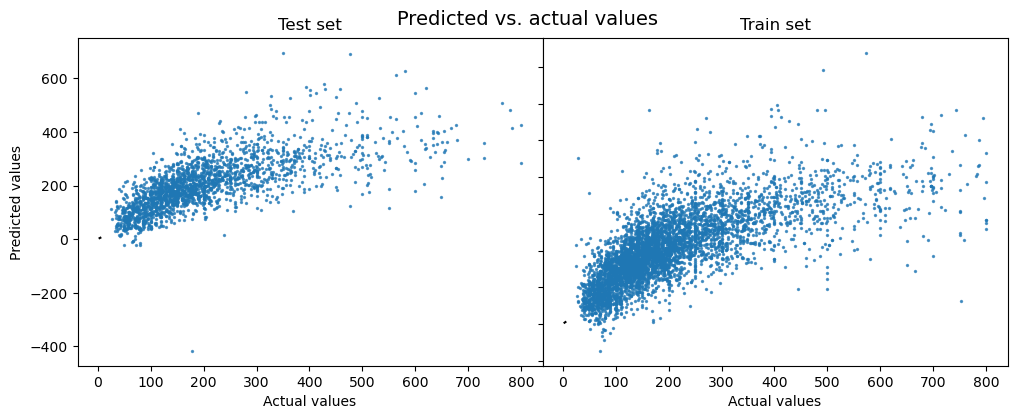

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)
    
ax1.scatter(y_test, y_test_pred_rr, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
    
ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')

plt.show()

In [32]:
X_test_scaled = sc.transform(df_test)

In [33]:
submission = ridge.predict(X_test_scaled)

submission

array([212.65264313, 143.54732396,  88.76072731, ..., 565.39814654,
        66.65563067, 173.55427175])

In [34]:
submission_file = pd.DataFrame(data={"ID":df_test["ID"],"price":submission})
file_path = '/Users/aadharbaheti/Downloads/submission.csv'

submission_file.to_csv(file_path, index=False)